<a href="https://colab.research.google.com/github/capgalea/CNN_Car_recognition/blob/main/CNN_Cars_train_predict_final2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

goo                                          #Deep Learning Model to Recognize Vehicle Accidents

In [1]:
from google.colab import drive, files
drive.mount('/content/gdrive')
gdrive_path = 'gdrive/My\ Drive/Colab\ Notebooks/'
!rsync -ah --progress\
    {gdrive_path}cars_dl/*.zip\
    {gdrive_path}model_weights_final*.h5\
    {gdrive_path}model_structure_final*.json\
    '/content'
!unzip -qo '*.zip'
!rm *.zip

Mounted at /content/gdrive
sending incremental file list
rsync: [sender] link_stat "/content/gdrive/My Drive/Colab Notebooks/model_structure_final*.json" failed: No such file or directory (2)
cars-20191002T050118Z-001.zip
        490.68M 100%   23.57MB/s    0:00:19 (xfr#1, to-chk=1/2)
model_weights_final.h5
          1.33M 100%    1.08MB/s    0:00:01 (xfr#2, to-chk=0/2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


In [2]:
!pip install tensorflow keras

##Import Keras library and packages

In [3]:
# Importing the Keras libraries and packages
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras import backend as K
from keras.preprocessing import image
from keras import regularizers
import tensorflow as tf
from PIL import Image
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os

##Set parameters

In [4]:
epochs = 50 #@param {type:"number"}
validation_steps = 32 #@param {type:"number"}
img_height = 128 #@param {type:"integer"}
img_width = 128 #@param {type:"integer"}
batch_size = 32 #@param {type:"number"}


##Set data filepaths

In [5]:
trainingCarImages = os.listdir('cars/training_set/car/')
print ("Number of Training car images - ",str(len(trainingCarImages)))

trainingCrashImages = os.listdir('cars/training_set/crash/')
print ("Number of Training crash images - ",str(len(trainingCrashImages)))

validCarImages = os.listdir('cars/val_set/car/')
print ("Number of Validation car images - ",str(len(validCarImages)))

validCrashImages = os.listdir('cars/val_set/crash/')
print ("Number of Validation crash images - ",str(len(validCrashImages)))

testCarImages = os.listdir('cars/test_set/car/')
print ("Number of Test car images - ",str(len(testCarImages)))

testCrashImages = os.listdir('cars/test_set/crash/')
print ("Number of Test crash images - ",str(len(testCrashImages)))

Number of Training car images -  1445
Number of Training crash images -  1445
Number of Validation car images -  375
Number of Validation crash images -  372
Number of Test car images -  129
Number of Test crash images -  131


##Print image from training folder

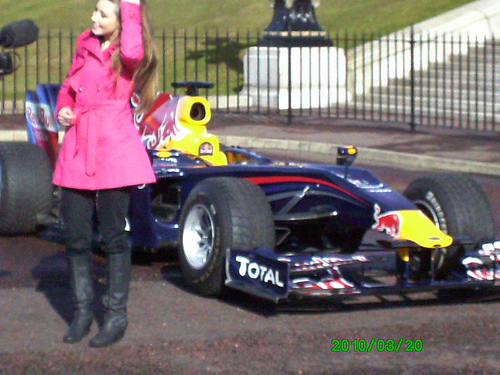

In [6]:
trainFilename = 'cars/training_set/car/'+trainingCarImages[2]
dimage = Image.open(trainFilename)
dimage

##Print image from validation folder

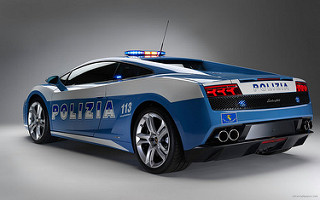

In [7]:
validFilename = 'cars/val_set/car/'+validCarImages[5]
dimage = Image.open(validFilename)
dimage

##Print image from test folder

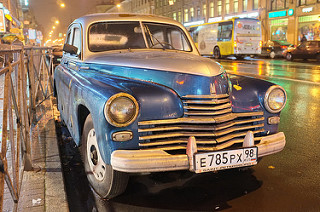

In [8]:
testFilename = 'cars/test_set/car/'+ testCarImages[29]
dimage = Image.open(testFilename)
dimage

###Determine image dimensions

In [9]:
train_data_dir = 'cars/training_set/'
validation_data_dir = 'cars/val_set/'
test_data_dir = 'cars/test_set/'
nb_train_samples = trainingCarImages + trainingCrashImages
nb_validation_samples = validCarImages + validCrashImages
nb_test_samples = testCarImages + testCrashImages

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

print(input_shape)

(128, 128, 3)


In [10]:
#Method to print several images in a single row
def plots(img, figsize=(12,6), rows = 1, titles = 1):
    if type(img[0]) is np.ndarray:
        img = np.array(img).astype(np.float_)
        if (img.shape[-1] != 3):
            img = img.transpose((0, 2, 3, 1))
    f =plt.figure(figsize = figsize)
    cols = 7//rows if (len(img) % 2 == 0) else len(img)//rows + 1
    for i in range(cols):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 10)
        plt.imshow(img[i], interpolation = None if np.interp else 'none')

##Create CNN model

In [11]:
# Initialising the CNN
classifier = Sequential()

# Layer 1 - convolution
classifier.add(Convolution2D(32, (3, 3),
              input_shape = (img_width, img_height, 3),
              activation = 'relu'))                        # Convolution
classifier.add(MaxPooling2D(pool_size = (2, 2)))          # MaxPooling
classifier.add(Dropout(0.25))                             # Dropout


#Add another convolutional layer
# classifier.add(Convolution2D(32, 3, 3,
#               activation = 'relu'))
# classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Layer 2 - convolution
classifier.add(Convolution2D(32, (3, 3),
              activation = 'relu',
              kernel_regularizer=regularizers.l2(0.01)))  # Convolution layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))          # MaxPooling
classifier.add(Dropout(0.25))                             # Dropout

# Layer 3 - convolution
classifier.add(Convolution2D(32, (3, 3),
              activation = 'relu'))                       # Convolution layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))          # MaxPooling
classifier.add(Dropout(0.25))                             # Dropout

# Layer 4 - convolution
classifier.add(Convolution2D(32, (3, 3),
              activation = 'relu'))                       # Convolution layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))          # MaxPooling
classifier.add(Dropout(0.25))                             # Dropout

classifier.add(Flatten())                                 # Flattening

# Fully connected layer
classifier.add(Dense(256, activation = 'relu'))                # Dense layer
classifier.add(Dropout(0.25))                             # Dropout
classifier.add(Dense(2, activation = 'softmax'))             # Output

classifier.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 324,322 (1.24 MB)

 Trainable params: 324,322 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

##Compiling the CNN

In [12]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

##Data standardization and augmentation of training data

In [13]:
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True
                                   )

training_set = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size = (img_width, img_height),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=42)

test_datagen = ImageDataGenerator(rescale = 1./255)

val_set = test_datagen.flow_from_directory(validation_data_dir,
                                            target_size = (img_width, img_height),
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle=True,
                                            seed=42)

test_set = test_datagen.flow_from_directory(test_data_dir,
                                            target_size = (img_width, img_height),
                                            batch_size = batch_size,
                                            class_mode = 'categorical'
                                            )


Found 2890 images belonging to 2 classes.
Found 747 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


##Print normalized and re-sized images from training set

In [17]:
imgs, labels = next(training_set)
#plots(imgs, titles = labels)



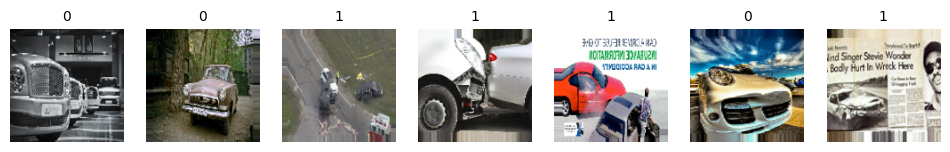

In [18]:
# Assuming 'labels' is a one-hot encoded array, convert it to a list of class indices
class_indices = np.argmax(labels, axis=1)

# Call plots with the class indices as titles
plots(imgs, titles=class_indices)

##Print normalized and re-sized images from validation set

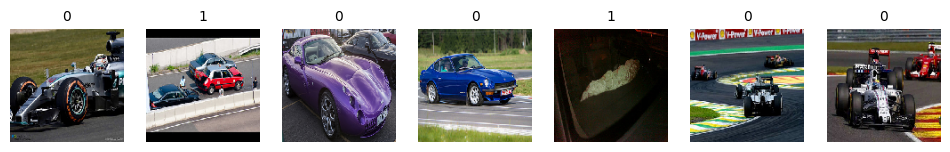

In [20]:
imgs, labels = next(val_set)
#plots(imgs, titles = labels)

# Assuming 'labels' is a one-hot encoded array, convert it to a list of class indices
class_indices = np.argmax(labels, axis=1)

# Call plots with the class indices as titles
plots(imgs, titles=class_indices)

In [21]:
#Method to identify and remove corrupted images
def my_gen(gen):
    while True:
        try:
            imgs, labels = next(gen)
            yield imgs, labels
        except:
            pass

##Training the CNN model

In [22]:
history = classifier.fit(my_gen(training_set),
                         steps_per_epoch = 78,
                         epochs = epochs,
                         validation_data = val_set,
                         validation_steps = validation_steps)

Epoch 1/50
37/78 ━━━━━━━━━━━━━━━━━━━━ 12s 302ms/step - accuracy: 0.5477 - loss: 0.9689

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.5540 - loss: 0.9175

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 400ms/step - accuracy: 0.5542 - loss: 0.9165 - val_accuracy: 0.6881 - val_loss: 0.7060
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 33s 433ms/step - accuracy: 0.6367 - loss: 0.6921 - val_accuracy: 0.6720 - val_loss: 0.6216
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 318ms/step - accuracy: 0.7186 - loss: 0.6030 - val_accuracy: 0.7805 - val_loss: 0.5140
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 345ms/step - accuracy: 0.7150 - loss: 0.5982 - val_accuracy: 0.8072 - val_loss: 0.4826
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 26s 339ms/step - accuracy: 0.7293 - loss: 0.5707 - val_accuracy: 0.7952 - val_loss: 0.4957
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 25s 325ms/step - accuracy: 0.7450 - loss: 0.5480 - val_accuracy: 0.6841 - val_loss: 0.5537
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 363ms/step - accuracy: 0.7352 - loss: 0.5366 - val_accuracy: 0.7376 - val_loss: 0.5104
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 313ms/step - accuracy: 0.7671 - loss: 0.5145 - val_accuracy: 0.673

In [23]:
# list all data in history
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [27]:
!ls '/My Drive/Colab Notebooks'

ls: cannot access '/My Drive/Colab Notebooks/': No such file or directory


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Save neural network structure

In [28]:
from pathlib import Path
import os
model_struct_final = classifier.to_json()
f = Path("/content/drive/My Drive/Colab Notebooks/model_struct_final.json")
f.write_text(model_struct_final)

9823

## Save neural network's trained weights

In [32]:
# Save neural network's trained weights
classifier.save_weights("/content/drive/My Drive/Colab Notebooks/CNN_Cars.weights.h5")

##Plot training and validation accuracy per epoch

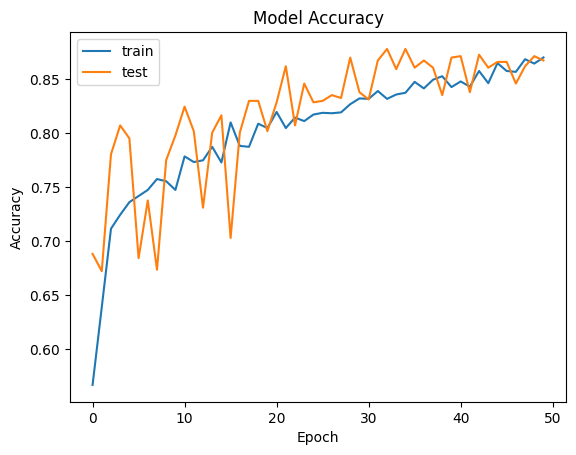

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Plot training and validation loss per epoch

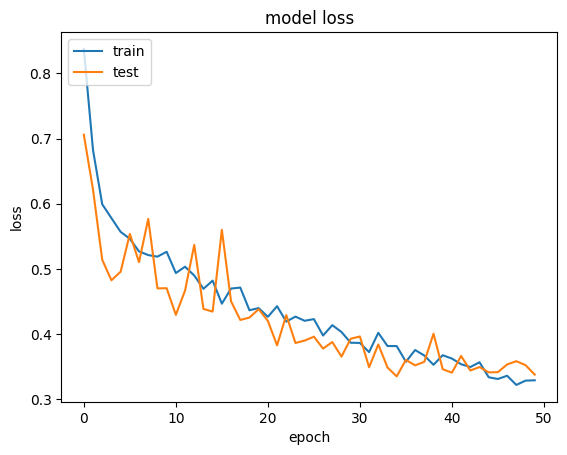

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
training_set.class_indices

{'car': 0, 'crash': 1}

##Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0.7540745
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0.0027942848
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.11346332
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.014990748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.9999621
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.028001018
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.97658825


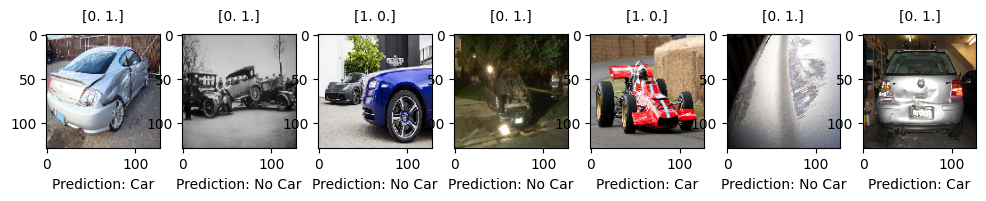

In [71]:
#Method to print several images in a single row
def plots(img, figsize=(12,6), rows = 1, titles = 1):

  if type(img[0]) is np.ndarray:
    img = np.array(img).astype(np.float_)
  if (img.shape[-1] != 3):
    img = img.transpose((0, 2, 3, 1))
  f =plt.figure(figsize = figsize)
  cols = 7//rows if (len(img) % 2 == 0) else len(img)//rows + 1

  for i in range(cols):
    sp = f.add_subplot(rows, cols, i+1)
    sp.axis('On')

    result = classifier.predict(img)
    print(result[i][0])
    test_set.class_indices
    if result[i][0] < 0.3:
      prediction = 'No Car'
    elif result[i][0] > 0.7:
      prediction = 'Car'
    else:
      prediction = 'Unsure'

    if titles is not None:
      # Accessing the correct element of the titles array
      sp.set_title(str(titles[i]), fontsize = 10, pad = 10) # Changed titles[i] to str(titles[i]) to convert the array element to a string
      sp.set_xlabel('Prediction: ' + prediction)
    plt.imshow(img[i], interpolation = None if np.interp else 'none')


imgs, labels = next(test_set)
plots(imgs, titles = labels)

###Process images and store in different folder

In [69]:
import os, shutil

# The directory where we will store our cars dataset
base_dir = 'cars_pro/'

# Check if the directory exists
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
else:
    print(f"Directory '{base_dir}' already exists.")


# Directories for our training, validation and test splits
test_dir = os.path.join(base_dir, 'test_set_pro')

# Check if the directory exists
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
else:
    print(f"Directory '{test_dir}' already exists.")


Directory 'cars_pro/' already exists.
Directory 'cars_pro/test_set_pro' already exists.


In [56]:
!pip install tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Use tensorflow.keras for ImageDataGenerator
from pathlib import Path


test_data_dir = 'cars/test_set/'

# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(128, 128),
    batch_size=10,
    class_mode = 'categorical')

print("OK")
for data_batch, labels_batch in test_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

Found 260 images belonging to 2 classes.
OK
data batch shape: (10, 128, 128, 3)
labels batch shape: (10, 2)


In [57]:
# This is module with image preprocessing utilities
from keras.preprocessing import image
import matplotlib.pyplot as plt
from numpy import ndarray # Changed import to numpy
import skimage as sk
from skimage import transform
from skimage import util

datagen = ImageDataGenerator(
    rescale=1./255
    )

test_data_dir = 'cars/test_set/car/'
fnames = [os.path.join(test_data_dir, fname) for fname in os.listdir(test_data_dir)]

for i in range(1, len(fnames), 1):
  # We pick one image to "augment"
  img_path = fnames[i]

  # Read the image and resize it
  img = image.load_img(img_path, target_size=(128, 128))

  # Convert it to a Numpy array with shape (128, 128, 3)
  x = image.img_to_array(img)

  # Reshape it to (1, 128, 128, 3)
  x = x.reshape((1,) + x.shape)

  car_pro_dir = 'cars_pro/'
  img.save(os.path.join(car_pro_dir, 'car' + str(i) + '.jpg'))


##Confusion matrix and classification report

In [73]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion_matrix(y_true, y_pred)

!pip install scikit-learn


In [80]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Method to print several images in a single row
def plots(img, labels, figsize=(12,6), rows = 1, titles=None):

  if type(img[0]) is np.ndarray:
    img = np.array(img).astype(np.float_)
  if (img.shape[-1] != 3):
    img = img.transpose((0, 2, 3, 1))
  f =plt.figure(figsize = figsize)
  cols = 7//rows if (len(img) % 2 == 0) else len(img)//rows + 1

  # Store predictions for confusion matrix
  predictions = []

  for i in range(len(img)):
    sp = f.add_subplot(rows, cols, i+1)
    sp.axis('On')

    # This part needs to be adapted to your specific prediction method
    # For demonstration purposes, I'm assigning random predictions here
    result = np.random.rand(1,2)

    if result[0][0] < 0.3:
      prediction = 'No Car'
    elif result[0][0] > 0.7:
      prediction = 'Car'
    else:
      prediction = 'Unsure'

    predictions.append(prediction)

    if titles is not None:
      sp.set_title(str(titles[i]), fontsize = 10, pad = 10)
    sp.set_xlabel('Prediction: ' + prediction)
    plt.imshow(img[i], interpolation = None if np.interp else 'none')

  # Generate confusion matrix
  cm = confusion_matrix(labels, predictions, labels=['Car', 'No Car', 'Unsure'])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Car', 'No Car', 'Unsure'])
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  # Sample data for testing
  imgs = np.random.rand(10, 128, 128, 3) # Replace with your actual image data
  labels = ['Car' if i%2 == 0 else 'No Car' for i in range(10)] # Replace with your actual labels

  plots(imgs, labels)